# C-VAE for MNIST


In [ ]:
!pip install scanpy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import scanpy as sc

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set Hyper-parameters (change None)
BATCH_SIZE = 64
LEARNING_RATE = 0.001
N_EPOCH = 20

In [ ]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=original_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=original_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
  class CVAE(nn.Module):
    def __init__(self, x_dim, z_dim, c_dim, hidden1_dim, hidden2_dim):
        super(CVAE, self).__init__()
        
        # encoder
        self.fc1 = nn.Linear(x_dim + c_dim, hidden1_dim)
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.fc3_1 = nn.Linear(hidden2_dim, z_dim)
        self.fc3_2 = nn.Linear(hidden2_dim, z_dim)
        #######################################
        ##       Defining Encoder layers     ##
        ## use linear or convolutional layer ##
        #######################################
        
        # decoder part
        self.fc4 = nn.Linear(z_dim + c_dim, hidden2_dim)
        self.fc5 = nn.Linear(hidden2_dim, hidden1_dim)
        self.fc6 = nn.Linear(hidden1_dim, x_dim)
        #######################################
        ##       Defining Decoder layers     ##
        ## use linear or convolutional layer ##
        #######################################
    
    def encoder(self, x, c):

        concat_input = torch.cat([x, c], 1)
        h = F.relu(self.fc1(concat_input))
        h = F.relu(self.fc2(h))
        return self.fc3_1(h), self.fc3_2(h)
    
    def decoder(self, z, c):

        concat_input = torch.cat([z, c], 1)
        h = F.relu(self.fc4(concat_input))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) 
    
    
    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

In [ ]:
# Create Model (change None)
cond_dim = len(train_loader.dataset.targets.unique())
latent_dim = 4
data_dim = train_loader.dataset.data.size(1) * train_loader.dataset.data.size(2)
cvae = CVAE(x_dim=data_dim, z_dim=latent_dim, c_dim=cond_dim,
            hidden1_dim=512, hidden2_dim=256)

# Device setting
cvae = cvae.to(device)

In [ ]:
# Your Model
cvae

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3_1): Linear(in_features=256, out_features=4, bias=True)
  (fc3_2): Linear(in_features=256, out_features=4, bias=True)
  (fc4): Linear(in_features=14, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    kl_loss = 0.5 * torch.sum(log_var.exp() + mu.pow(2) - 1 - log_var)
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return 1 * kl_loss + 1 * recon_loss #You can change constants

In [ ]:
# one-hot encoding
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

### 'test' function is added to evaluate trained model after each epoch.

In [ ]:
def test():
    cvae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, cond in test_loader:
            data = data.to(device)

            cond = one_hot(cond, cond_dim) # create one-hot condition
            cond = cond.to(device)
            
            recon, mu, log_var = cvae(data, cond)
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
# Train
for epoch in range(1, N_EPOCH + 1):
    cvae.train()
    train_loss = 0
    for (data, cond) in train_loader:
        data = data.to(device)
        
        cond = one_hot(cond, cond_dim) # create one-hot condition
        cond = cond.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = cvae(data, cond)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {}/{}\t Average loss: {:.4f}'.format(epoch, N_EPOCH, train_loss / len(train_loader.dataset)))
    test()

Epoch: 1/20	 Average loss: 150.3924
====> Test set loss: 128.4378
Epoch: 2/20	 Average loss: 125.7978
====> Test set loss: 123.0851
Epoch: 3/20	 Average loss: 121.7774
====> Test set loss: 120.1968
Epoch: 4/20	 Average loss: 119.4802
====> Test set loss: 118.9847
Epoch: 5/20	 Average loss: 117.8905
====> Test set loss: 117.6552
Epoch: 6/20	 Average loss: 116.6826
====> Test set loss: 116.8666
Epoch: 7/20	 Average loss: 115.8002
====> Test set loss: 116.0577
Epoch: 8/20	 Average loss: 115.0179
====> Test set loss: 115.5806
Epoch: 9/20	 Average loss: 114.4097
====> Test set loss: 114.8282
Epoch: 10/20	 Average loss: 113.8508
====> Test set loss: 114.7041
Epoch: 11/20	 Average loss: 113.4063
====> Test set loss: 114.8583
Epoch: 12/20	 Average loss: 112.9883
====> Test set loss: 113.9653
Epoch: 13/20	 Average loss: 112.6296
====> Test set loss: 113.9503
Epoch: 14/20	 Average loss: 112.2801
====> Test set loss: 114.0056
Epoch: 15/20	 Average loss: 112.0282
====> Test set loss: 113.6419
Epoc

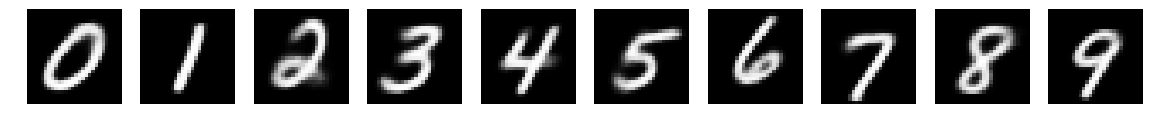

In [ ]:
# Visualization
import matplotlib.pyplot as plt

digit_size = 28
z_sample = torch.rand(1, latent_dim) # random 
z_sample = z_sample.to(device)

plt.figure(figsize=(20, 20))

for i in range(10):
    c = torch.zeros(1, cond_dim)
    c[0][i] = 1
    c = c.to(device)

    cvae.eval()
    with torch.no_grad():
        img = cvae.decoder(z_sample, c).cpu()
        img = torch.reshape(img, (28, 28))

    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(img.cpu(), cmap='Greys_r',)
plt.show()


In [ ]:
# Create latent space and labels for UMAP
cvae.eval()
latent = None
labels = None
with torch.no_grad():
    for data, cond in test_loader:
        data = data.to(device)
        
        if labels is None:
            labels = cond
        else:
            labels = np.concatenate((labels, cond))# concatenate labels and cond
            
        cond = one_hot(cond, cond_dim) # create one-hot condition
        cond = cond.to(device)
        
        mu_out, log_var_out = cvae.encoder(data.view(-1, 784), cond)
        batch_latent = cvae.sampling(mu_out, log_var_out).cpu()

        if latent is None:
            latent = batch_latent
        else:
            latent = np.concatenate((latent, batch_latent), axis=0) # concatenate latent and batch_latent

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True

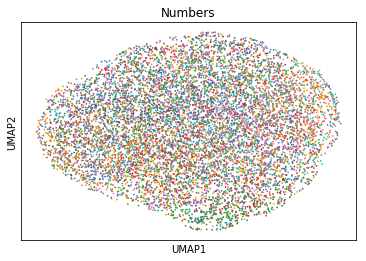

In [ ]:
# UMAP
import scanpy as sc

labels = labels.astype(str)
latent_anndata = sc.AnnData(X=latent,
                        obs={"Numbers": labels})
sc.pp.neighbors(latent_anndata)
sc.tl.umap(latent_anndata)

# Visualization
sc.pl.umap(latent_anndata, color=["Numbers"],
           frameon=True,
           legend_loc=False,
           show=True)